In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import tensorflow_probability as tfp
# import tensorflow_data_validation as tfdv # blursed library
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae

In [2]:
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)

# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [3]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [6]:
processed_df = pd.read_csv('processed_data.csv', index_col=0)

In [7]:
processed_df.head(3)

,encounter_id,patient_nbr,bias,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,time_in_hospital,race,gender,age,max_glu_serum,A1Cresult,change,readmitted,acarbose,glimepiride,glipizide,glipizide_and_metformin_hcl,glipizide_and_metformin_hydrochloride,glyburide,glyburide_and_metformin_hydrochloride,glyburide-metformin_hydrochloride,human_insulin,insulin_human,metformin_hcl,metformin_hydrochloride,miglitol,nateglinide,none,pioglitazole_and_metformin_hydrochloride,pioglitazone,pioglitazone_hydrochloride_and_glimepiride,repaglinide,rosiglitazone_maleate,tolazamide,tolbutamide
0,12522,48330783,1.0,-0.262004,-0.294524,-0.203346,1.249212,0.378159,1.479343,0.323563,13.0,Caucasian,Female,[80-90),None,None,Ch,NO,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,1.0,-0.262004,-0.294524,-0.203346,-0.504981,0.378159,0.276134,0.891793,12.0,Caucasian,Female,[90-100),None,None,Ch,NO,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,42519267,1.0,-0.262004,-0.294524,-0.203346,0.397175,-1.125856,-0.927076,-0.812896,1.0,Caucasian,Male,[40-50),None,None,Ch,NO,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
numeric = [
    'bias',
    'number_outpatient', 
    'number_inpatient', 
    'number_emergency', 
    'num_lab_procedures',
    'number_diagnoses',
    'num_medications',
    'num_procedures']

categorical = [
    'race',
    'gender',
    'age',
    'max_glu_serum',
    'A1Cresult',
    'change',
    'readmitted'
]

ids = [
    'encounter_id',
    'patient_nbr'
]

target = ['time_in_hospital']

other = [
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id',
    'other_diagnosis_codes',
    'primary_diagnosis_code',
    'ndc_code',
    'medical_specialty',
    'payer_code',
    'weight',
    'generic_drug_name',
]

allcols = numeric + categorical + ids + target + other

In [9]:
[c for c in processed_df.columns if c not in allcols]

['acarbose',
 'glimepiride',
 'glipizide',
 'glipizide_and_metformin_hcl',
 'glipizide_and_metformin_hydrochloride',
 'glyburide',
 'glyburide_and_metformin_hydrochloride',
 'glyburide-metformin_hydrochloride',
 'human_insulin',
 'insulin_human',
 'metformin_hcl',
 'metformin_hydrochloride',
 'miglitol',
 'nateglinide',
 'none',
 'pioglitazole_and_metformin_hydrochloride',
 'pioglitazone',
 'pioglitazone_hydrochloride_and_glimepiride',
 'repaglinide',
 'rosiglitazone_maleate',
 'tolazamide',
 'tolbutamide']

In [10]:
len(processed_df.columns)

40

In [11]:
print(f"""
Numeric: {len(numeric)}
Categorical: {len(categorical)}
ID/Other: {len(other) + len(ids) + len(target)}
Total: {len(numeric) + len(categorical) + len(other) + len(ids) + len(target)}
""")


Numeric: 8
Categorical: 7
ID/Other: 13
Total: 28



In [12]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [c for c in df.columns if c not in ids + numeric + target + other]
student_numerical_col_list = numeric
PREDICTOR_FIELD = 'time_in_hospital'

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [13]:
processed_df = pd.read_csv('processed_data.csv', index_col=0)

In [14]:
processed_df.head(3)

,encounter_id,patient_nbr,bias,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,time_in_hospital,race,gender,age,max_glu_serum,A1Cresult,change,readmitted,acarbose,glimepiride,glipizide,glipizide_and_metformin_hcl,glipizide_and_metformin_hydrochloride,glyburide,glyburide_and_metformin_hydrochloride,glyburide-metformin_hydrochloride,human_insulin,insulin_human,metformin_hcl,metformin_hydrochloride,miglitol,nateglinide,none,pioglitazole_and_metformin_hydrochloride,pioglitazone,pioglitazone_hydrochloride_and_glimepiride,repaglinide,rosiglitazone_maleate,tolazamide,tolbutamide
0,12522,48330783,1.0,-0.262004,-0.294524,-0.203346,1.249212,0.378159,1.479343,0.323563,13.0,Caucasian,Female,[80-90),None,None,Ch,NO,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,1.0,-0.262004,-0.294524,-0.203346,-0.504981,0.378159,0.276134,0.891793,12.0,Caucasian,Female,[90-100),None,None,Ch,NO,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,42519267,1.0,-0.262004,-0.294524,-0.203346,0.397175,-1.125856,-0.927076,-0.812896,1.0,Caucasian,Male,[40-50),None,None,Ch,NO,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [16]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [17]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == processed_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Lost EDA

## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

In [18]:
splits = [processed_df, d_train, d_val, d_test]
snames = ['Full', 'Train', 'Validation', 'Test']

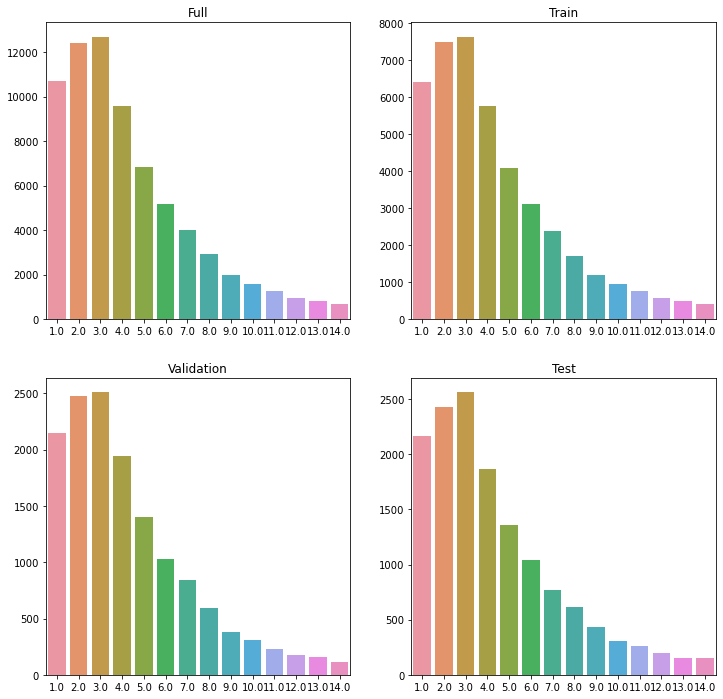

In [19]:
plt.figure(figsize=(12,12))
for i in range(len(splits)):
    plt.subplot(2, 2, i+1)
    plt.title(snames[i])
    y = splits[i].groupby(PREDICTOR_FIELD).size()
    sns.barplot(sorted(processed_df[PREDICTOR_FIELD].unique()), y)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

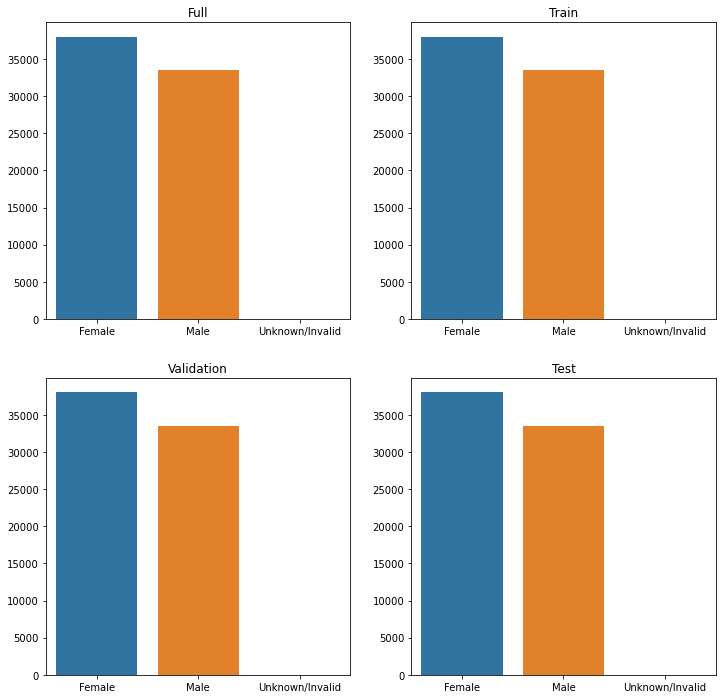

In [20]:
plt.figure(figsize=(12,12))
for i in range(len(splits)):
    plt.subplot(2, 2, i+1)
    plt.title(snames[i])
    sns.barplot(sorted(processed_df.gender.unique()), processed_df.groupby('gender').size())

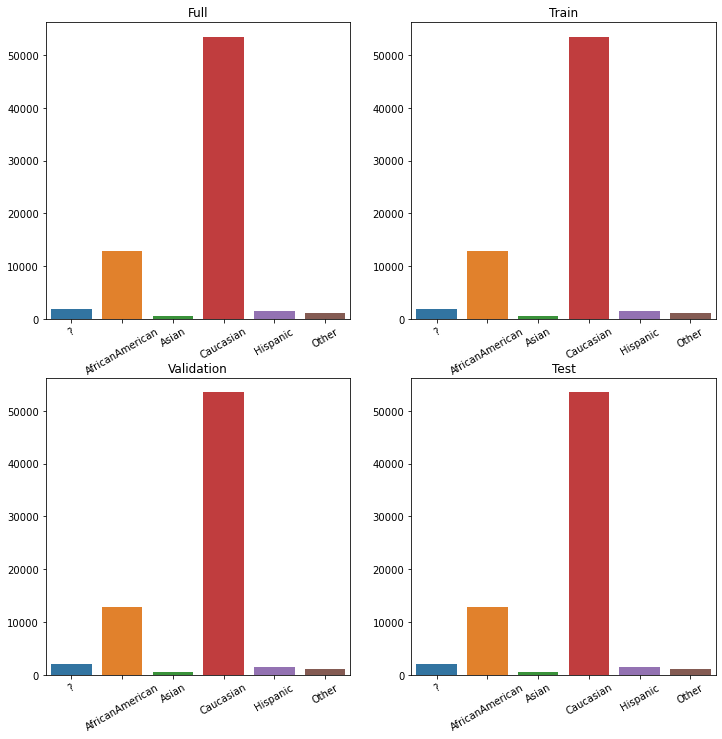

In [21]:
plt.figure(figsize=(12,12))
for i in range(len(splits)):
    plt.subplot(2, 2, i+1)
    plt.title(snames[i])
    plt.xticks(rotation=30)
    sns.barplot(sorted(processed_df.race.unique()), processed_df.groupby('race').size())

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

We need to drop the UID columns at this point and retain only our data columns. _(I suspect that the TF input layer actually removes the need for this but better safe than sorry)_

In [22]:
dcols = d_train.columns[2:]
dcols

Index(['bias', 'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures', 'time_in_hospital', 'race', 'gender', 'age',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted', 'acarbose',
       'glimepiride', 'glipizide', 'glipizide_and_metformin_hcl',
       'glipizide_and_metformin_hydrochloride', 'glyburide',
       'glyburide_and_metformin_hydrochloride',
       'glyburide-metformin_hydrochloride', 'human_insulin', 'insulin_human',
       'metformin_hcl', 'metformin_hydrochloride', 'miglitol', 'nateglinide',
       'none', 'pioglitazole_and_metformin_hydrochloride', 'pioglitazone',
       'pioglitazone_hydrochloride_and_glimepiride', 'repaglinide',
       'rosiglitazone_maleate', 'tolazamide', 'tolbutamide'],
      dtype='object')

In [23]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(target)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds


In [24]:
BATCH_SIZE = 32

diabetes_train_ds = df_to_dataset(d_train[dcols], PREDICTOR_FIELD, shuffle=True, batch_size=BATCH_SIZE)
diabetes_val_ds = df_to_dataset(d_val[dcols], PREDICTOR_FIELD, shuffle=False, batch_size=BATCH_SIZE)
diabetes_test_ds = df_to_dataset(d_test[dcols], PREDICTOR_FIELD, shuffle=False, batch_size=BATCH_SIZE)

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

_Note: Switched to non-filepath method but completed the function in the code file_

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [25]:
features = []

for c in numeric:
    features.append(feature_column.numeric_column(c))

for c in categorical:
    vocab = processed_df[c].unique()
    ft = feature_column.categorical_column_with_vocabulary_list(c, vocab)
    features.append(feature_column.indicator_column(ft))

In [26]:
features

[NumericColumn(key='bias', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='number_outpatient', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='number_inpatient', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='number_emergency', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='num_lab_procedures', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='number_diagnoses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='num_medications', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='num_procedures', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='race', vocabulary_list=('Caucasian', 'AfricanAmerican', '?'

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [27]:
input_layer = tf.keras.layers.DenseFeatures(features)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

**Network Architecture and Bias/Variance:** Given that, after reducing the number of dimensions, the dataset contains a smaller number of features (the majority of which are the generic drug dummy variables) I felt it was unlikely that the dataset would run into issues with overfitting if more layers were added. I added several dense layers bringing the total params up to ~200K, much more expressive than a simple regression (which would have ~40 params), but similarly far less than a very dense and very deep network which could have tens of millions of params to train. Experimentally this seemed to offer modest improvements over simpler architectures without overfitting.

I also removed the `DenseVariational` layer for two reasons: 1) It will generate different results every time the priors are added to the layer after training which makes it difficult to debug, but primarily 2) it raised the overall loss metric significantly and changes in the learning rate/architecture were unable to overcome this. 

In [28]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1 + 1),
#         tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model = build_sequential_model(input_layer)
modelpath = os.path.join('.', 'model', 'diabetes_model.skpt')
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
stop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)
model.compile(optimizer=optim, loss=negloglik, metrics=['mse'])

In [71]:
epochs = 100
history = model.fit(diabetes_train_ds, validation_data=diabetes_val_ds,
                    epochs=epochs, callbacks=[stop])

Train for 1341 steps, validate for 447 steps
Epoch 1/100
1341/1341 [==============================] - 10s 8ms/step - loss: 2.9027 - mse: 11.8910 - val_loss: 2.3189 - val_mse: 13.6499
Epoch 2/100
1341/1341 [==============================] - 10s 7ms/step - loss: 2.2924 - mse: 12.2796 - val_loss: 2.3475 - val_mse: 12.8866
Epoch 3/100
1341/1341 [==============================] - 9s 6ms/step - loss: 2.2874 - mse: 12.1453 - val_loss: 2.2673 - val_mse: 11.3806
Epoch 4/100
1341/1341 [==============================] - 9s 7ms/step - loss: 2.2796 - mse: 12.1001 - val_loss: 2.3172 - val_mse: 13.8842
Epoch 5/100
1341/1341 [==============================] - 9s 6ms/step - loss: 2.2751 - mse: 12.1185 - val_loss: 2.2614 - val_mse: 11.4669
Epoch 6/100
1341/1341 [==============================] - 9s 7ms/step - loss: 2.2658 - mse: 11.9499 - val_loss: 2.2934 - val_mse: 12.3572
Epoch 7/100
1341/1341 [==============================] - 10s 7ms/step - loss: 2.2595 - mse: 11.7901 - val_loss: 2.2541 - val_mse: 1

In [72]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_1 (DenseFeatu multiple                  0         
_________________________________________________________________
dense_20 (Dense)             multiple                  20992     
_________________________________________________________________
dense_21 (Dense)             multiple                  131328    
_________________________________________________________________
dense_22 (Dense)             multiple                  32896     
_________________________________________________________________
dense_23 (Dense)             multiple                  8256      
_________________________________________________________________
dense_24 (Dense)             multiple                  130       
_________________________________________________________________
distribution_lambda_4 (Distr multiple                 

In [101]:
model.save_weights(modelpath)

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [29]:
model = build_sequential_model(input_layer)
model.load_weights(modelpath)

In [30]:
# feature_list = student_categorical_col_list + student_numerical_col_list
feature_list = [c for c in d_test.columns if c != 'time_in_hospital']
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = model(diabetes_x_tst)
preds = model.predict(diabetes_test_ds)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


In [31]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [32]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [33]:
len(prob_output_df)

14304

In [34]:
prob_output_df.head(10)

,pred,actual_value,pred_mean,pred_std
0,5.945456,3.0,2.537642,1.728768
1,6.724997,5.0,7.984324,2.998356
2,6.662012,8.0,7.529450,2.075785
3,7.594665,8.0,4.473454,2.474643
4,1.885892,6.0,3.412266,1.872985
5,2.220034,4.0,2.017311,1.329459
6,2.251939,3.0,2.493691,1.496531
7,5.545232,1.0,3.045019,1.542586
8,-0.060459,10.0,3.747425,2.195255
9,4.789576,4.0,3.151385,1.588177


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [35]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

In [36]:
labels = d_test.time_in_hospital.map(lambda x: 1 if x >= 5 else 0)

In [37]:
student_binary_prediction.sum() / len(student_binary_prediction)

0.23566834451901567

In [38]:
labels.sum() / len(labels)

0.3691275167785235

In [39]:
assert len(student_binary_prediction) == len(labels)

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [45]:
cols = ['patient_nbr', 'race', 'gender', 'age', 'time_in_hospital']
labels = d_test.time_in_hospital.map(lambda x: 1 if x >= 5 else 0)

In [46]:
demo_df = d_test[cols].copy()
demo_df['label_value'] = labels
demo_df['score'] = student_binary_prediction

In [47]:
demo_df

,patient_nbr,race,gender,age,time_in_hospital,label_value,score
12496,20188809,AfricanAmerican,Female,[50-60),3.0,0,0
29681,19749510,Caucasian,Male,[50-60),5.0,1,1
6193,5209488,AfricanAmerican,Female,[70-80),8.0,1,1
11307,6098067,Caucasian,Male,[80-90),8.0,1,0
23324,18154584,?,Male,[50-60),6.0,1,0
...,...,...,...,...,...,...,...
71096,85488858,Caucasian,Female,[70-80),5.0,1,0
17747,23404635,Caucasian,Male,[50-60),4.0,0,0
68671,125221334,Caucasian,Female,[60-70),5.0,1,1
60327,85667580,Caucasian,Male,[30-40),2.0,0,0


In [48]:
pred_test_df = demo_df

In [49]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']]

,patient_nbr,gender,race,time_in_hospital,score,label_value
12496,20188809,Female,AfricanAmerican,3.0,0,0
29681,19749510,Male,Caucasian,5.0,1,1
6193,5209488,Female,AfricanAmerican,8.0,1,1
11307,6098067,Male,Caucasian,8.0,0,1
23324,18154584,Male,?,6.0,0,1
...,...,...,...,...,...,...
71096,85488858,Female,Caucasian,5.0,0,1
17747,23404635,Male,Caucasian,4.0,0,0
68671,125221334,Female,Caucasian,5.0,1,1
60327,85667580,Male,Caucasian,2.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, classification_report

In [52]:
roc_auc_score(labels, student_binary_prediction)

0.6950868391360413

In [56]:
f1_score(labels, student_binary_prediction, average='weighted')

0.7353390857512828

In [54]:
precision_score(labels, student_binary_prediction)

0.7546722040937407

In [55]:
recall_score(labels, student_binary_prediction)

0.4818181818181818

In [60]:
classification_report(labels, student_binary_prediction, output_dict=True)

{'0': {'precision': 0.7497484679410957,
  'recall': 0.9083554964539007,
  'f1-score': 0.8214661522272887,
  'support': 9024},
 '1': {'precision': 0.7546722040937407,
  'recall': 0.4818181818181818,
  'f1-score': 0.5881400994104728,
  'support': 5280},
 'accuracy': 0.7509088366890381,
 'macro avg': {'precision': 0.7522103360174182,
  'recall': 0.6950868391360412,
  'f1-score': 0.7048031258188807,
  'support': 14304},
 'weighted avg': {'precision': 0.7515659544403942,
  'recall': 0.7509088366890381,
  'f1-score': 0.7353390857512828,
  'support': 14304}}

### Summary

The model was trained as a regression model to predict the number of days of hospitalization, from that we selected patients who were predicted to require five or more days of hospitalization and compared these to the actual values.

There are very few strong correlations here to help our predictions, so rather than look at the overall accuracy of the model, which is affected by the general complexity of the problem, we should instead look at how it performs on the problem we are targeting: Finding patients who will require five or more days of hospitalization, ie: the `1` group in our classification report. In this the model performs well, with 75% of the predictions being accurate. Normally achieving a higher precision worsens the overall recall (the number of positives that we detected out of the total). That pattern continues here with recall being less than 50%, but for the purposes of the problem we are primarily interested in finding a "sure thing" and the tradeoff the model exhibits is well suited for that.

Beyond that, and on a more technical note, we see that the AUC score along with the weighted precision, recall, and F1 scores all show that our model performs well above random chance in making these selections. Future improvements on this algorithm would likely delve into clinical knowledge regarding the diagnosis codes and identifying specific diagnoses that have a known correlation with longer hospitalization. The current model does not consider diagnoses as there are so many that it becomes hard to draw relevant conclusions from them without either more data or better domain guidance.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [79]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

import aequitas as ae

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [3371]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [64]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

In [86]:
clean_xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,1,binary 0/1,3371,race,?,0.552239,0.929461,0.211268,0.186813,0.070539,0.447761,0.788732,0.813187,91,284,0.026995,0.242667,17,60,224,74,134,241,375,14304,0.357333
1,1,binary 0/1,3371,race,AfricanAmerican,0.481818,0.898097,0.259615,0.258165,0.101903,0.518182,0.740385,0.741835,643,1976,0.190745,0.245514,166,513,1463,477,990,1629,2619,14304,0.378007
2,1,binary 0/1,3371,race,Asian,0.538462,0.935897,0.141176,0.263158,0.064103,0.461538,0.858824,0.736842,19,85,0.005636,0.182692,5,12,73,14,26,78,104,14304,0.250000
3,1,binary 0/1,3371,race,Caucasian,0.473804,0.910000,0.254281,0.243636,0.090000,0.526196,0.745719,0.756364,2475,8176,0.734204,0.232373,603,2079,6097,1872,3951,6700,10651,14304,0.370951
4,1,binary 0/1,3371,race,Hispanic,0.576923,0.895928,0.181818,0.277108,0.104072,0.423077,0.818182,0.722892,83,242,0.024622,0.255385,23,44,198,60,104,221,325,14304,0.320000
5,1,binary 0/1,3371,race,Other,0.626667,0.916129,0.164706,0.216667,0.083871,0.373333,0.835294,0.783333,60,170,0.017799,0.260870,13,28,142,47,75,155,230,14304,0.326087
6,1,binary 0/1,3371,gender,Female,0.475364,0.904822,0.260286,0.248079,0.095178,0.524636,0.739714,0.751921,1822,5809,0.540492,0.238763,452,1512,4297,1370,2882,4749,7631,14304,0.377670
7,1,binary 0/1,3371,gender,Male,0.489575,0.912281,0.238876,0.242092,0.087719,0.510425,0.761124,0.757908,1549,5124,0.459508,0.232129,375,1224,3900,1174,2398,4275,6673,14304,0.359359


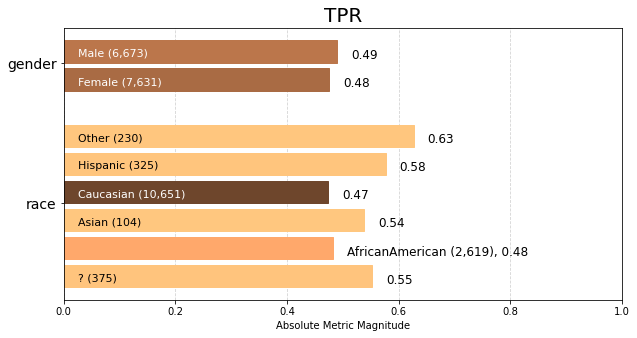

In [70]:
aqp.plot_group_metric(clean_xtab, 'tpr')

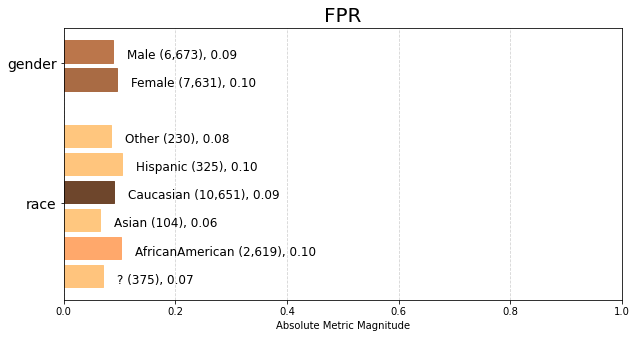

In [71]:
aqp.plot_group_metric(clean_xtab, 'fpr')

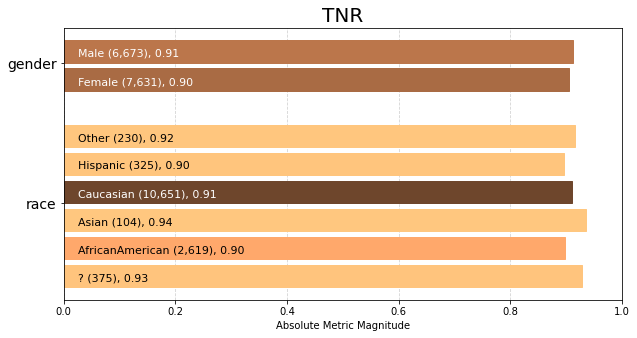

In [92]:
aqp.plot_group_metric(clean_xtab, 'tnr')

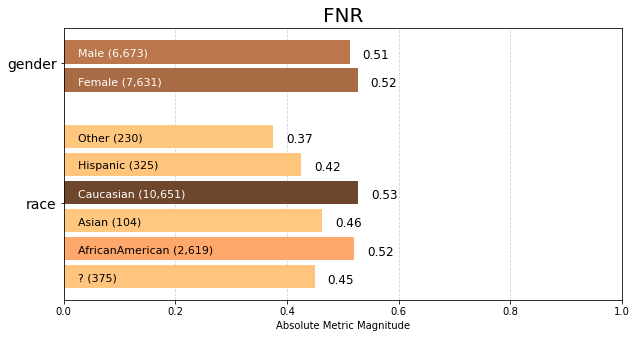

In [91]:
aqp.plot_group_metric(clean_xtab, 'fnr')

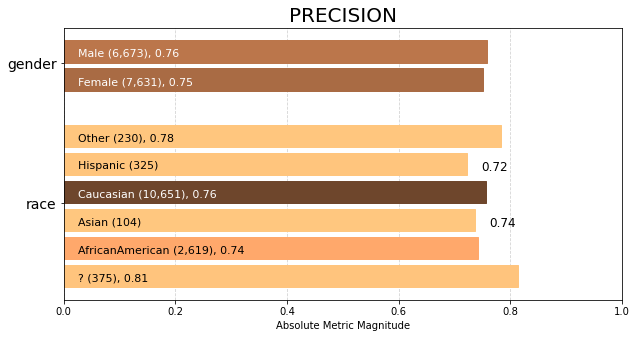

In [93]:
aqp.plot_group_metric(clean_xtab, 'precision')

### Interpretation

The model does not show significant bias in terms of how it classifies by either race or gender. While there are some discrepancies for both Caucasian and African-American populations in a few statistics (TPR, FNR, and somewhat in FPR) these are likely due to sampling issues considering these are the two largest groups. With more data on the other populations we would expect these to converge. 

Regarding gender there is minimal difference between male and female groups. 

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [99]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,3371,race,?,0.552239,0.929461,0.211268,0.186813,0.070539,0.447761,0.788732,0.813187,91,284,0.026995,0.242667,17,60,224,74,134,241,375,14304,0.357333,0.036768,1.044300,1.075127,0.766771,0.830844,0.783771,0.850940,1.165542,1.021385,1.057680,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,False,False,True,True,True,True,True,True,False,True,False,False,False
1,1,binary 0/1,3371,race,AfricanAmerican,0.481818,0.898097,0.259615,0.258165,0.101903,0.518182,0.740385,0.741835,643,1976,0.190745,0.245514,166,513,1463,477,990,1629,2619,14304,0.378007,0.259798,1.056551,0.980792,1.059632,1.020979,1.132256,0.984770,1.016914,0.986920,0.992846,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
2,1,binary 0/1,3371,race,Asian,0.538462,0.935897,0.141176,0.263158,0.064103,0.461538,0.858824,0.736842,19,85,0.005636,0.182692,5,12,73,14,26,78,104,14304,0.250000,0.007677,0.786204,0.974190,1.080126,0.555199,0.712251,0.877123,1.136464,1.028459,1.151672,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,False,True,True,True,True,True,False,False,False,False,False
3,1,binary 0/1,3371,race,Caucasian,0.473804,0.910000,0.254281,0.243636,0.090000,0.526196,0.745719,0.756364,2475,8176,0.734204,0.232373,603,2079,6097,1872,3951,6700,10651,14304,0.370951,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,1,binary 0/1,3371,race,Hispanic,0.576923,0.895928,0.181818,0.277108,0.104072,0.423077,0.818182,0.722892,83,242,0.024622,0.255385,23,44,198,60,104,221,325,14304,0.320000,0.033535,1.099031,0.955746,1.137385,0.715029,1.156360,0.804029,1.217641,0.984536,1.097171,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,False,True,True,True,True,True,True,False,True,False,False
5,1,binary 0/1,3371,race,Other,0.626667,0.916129,0.164706,0.216667,0.083871,0.373333,0.835294,0.783333,60,170,0.017799,0.260870,13,28,142,47,75,155,230,14304,0.326087,0.024242,1.122635,1.035657,0.889303,0.647732,0.931900,0.709495,1.322628,1.006735,1.120119,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,False,False,False,True,True,True,True,False,False,False,False
6,1,binary 0/1,3371,gender,Female,0.475364,0.904822,0.260286,0.248079,0.095178,0.524636,0.739714,0.751921,1822,5809,0.540492,0.238763,452,1512,4297,1370,2882,4749,7631,14304,0.377670,1.176243,1.028577,0.992100,1.024732,1.089628,1.085028,1.027840,0.970974,0.991824,0.971871,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,1,binary 0/1,3371,gender,Male,0.489575,0.912281,0.238876,0.242092,0.087719,0.510425,0.761124,0.757908,1549,5124,0.459508,0.232129,375,1224,3900,1174,2398,4275,6673,14304,0.359359,1.000000,

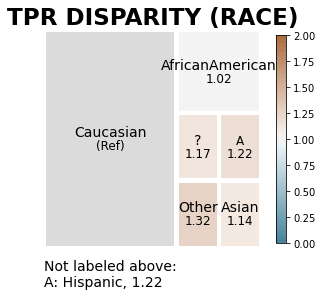

In [101]:
# Reference group fairness plot\
aqp.plot_disparity(fdf, group_metric='tpr_disparity', attribute_name='race')

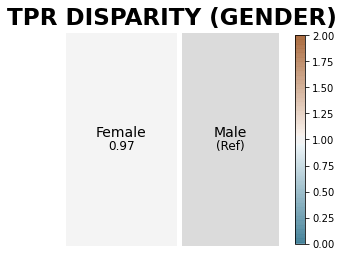

In [102]:
# Reference group fairness plot\
aqp.plot_disparity(fdf, group_metric='tpr_disparity', attribute_name='gender')

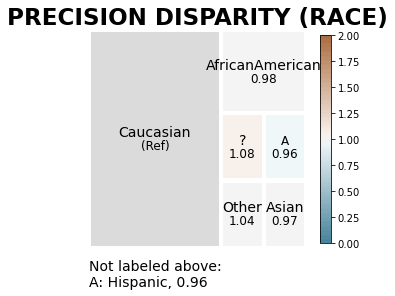

In [105]:
# Reference group fairness plot\
aqp.plot_disparity(fdf, group_metric='precision_disparity', attribute_name='race')

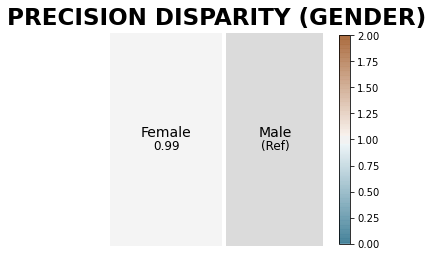

In [104]:
# Reference group fairness plot\
aqp.plot_disparity(fdf, group_metric='precision_disparity', attribute_name='gender')

### Interpretation

Looking at the statistics regarding group dispairites we once again see only minor differences. Where the differences exist they are hard to interpret, Both `Caucasian` and `African-American` have lower true-positive rates than the others, but also larger sample sizes. Given that the differences are potentially the result of sampling errors, and that they are not significant enough to affect the algorithm, we can say that the algorithm is unbiased with regards to race and gender in all the categories we have looked at.